# Graph에서 Node와 Edge 연결하기

## 1. 일련의 노드를 한번에 연결하기 (`.add_sequence`)

In [1]:
from typing_extensions import TypedDict

# Define State
class State(TypedDict):
    aggregates: str

In [2]:
# Define Nodes
def node_1(state: State):
    prev_val = state['aggregates']

    return {
        'aggregates' : prev_val + '_node1'
    }

def node_2(state: State):
    prev_val = state['aggregates']

    return {
        'aggregates' : prev_val + '_node2'
    }

def node_3(state: State):
    prev_val = state['aggregates']

    return {
        'aggregates' : prev_val + '_node3'
    }

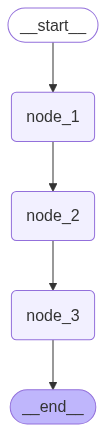

In [5]:
from langgraph.graph import StateGraph, START, END

# Define Graph Builder
workflow = StateGraph(State)

# add nodes and edges
workflow.add_sequence([node_1, node_2, node_3])
workflow.add_edge(START, "node_1")
workflow.add_edge("node_3", END)

# compile graph
app = workflow.compile()

app

In [6]:
app.invoke({"aggregates" : "hello"})

{'aggregates': 'hello_node1_node2_node3'}

## 2. 병렬로 연결하기

In [15]:
from typing import Annotated
from typing_extensions import TypedDict
from langchain_core.messages import (
    HumanMessage,
    AIMessage,
    AnyMessage
)
from langgraph.graph.message import add_messages
from operator import add

class GraphState(TypedDict):
    query: str
    messages: Annotated[list[AnyMessage], add_messages]

In [19]:
def node_a(state: GraphState):
    query = state['query']
    user_message = HumanMessage(content=query)

    cur_node = 'a'
    ai_message = AIMessage(content=f"저는 '{cur_node}'를 방문했습니다.")

    return {
        'messages' : [user_message, ai_message]
    }

def node_b(state: GraphState):
    cur_node = 'b'
    ai_message = AIMessage(content=f"저는 '{cur_node}'를 방문했습니다.")

    return {
        'messages' : [ai_message]
    }

def node_c(state: GraphState):
    cur_node = 'c'
    ai_message = AIMessage(content=f"저는 '{cur_node}'를 방문했습니다.")

    return {
        'messages' : [ai_message]
    }

def node_d(state: GraphState):
    cur_node = 'd'
    ai_message = AIMessage(content=f"저는 '{cur_node}'를 방문했습니다.")

    return {
        'messages' : [ai_message]
    }

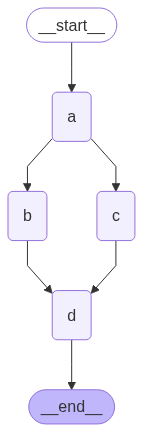

In [20]:
from langgraph.graph import StateGraph, START, END

workflow = StateGraph(
    GraphState
)

workflow.add_node("a", node_a)
workflow.add_node("b", node_b)
workflow.add_node("c", node_c)
workflow.add_node("d", node_d)

workflow.add_edge(START, "a")
workflow.add_edge("a", "b")
workflow.add_edge("a", "c")
workflow.add_edge("b", "d")
workflow.add_edge("c", "d")
workflow.add_edge("d", END)

app = workflow.compile()

app

In [21]:
app.invoke({"query" : "모든 노드를 지나가 보자!"})

{'query': '모든 노드를 지나가 보자!',
 'messages': [HumanMessage(content='모든 노드를 지나가 보자!', additional_kwargs={}, response_metadata={}, id='edacf190-3857-434e-a161-09ce13aa4eb1'),
  AIMessage(content="저는 'a'를 방문했습니다.", additional_kwargs={}, response_metadata={}, id='053f8fab-bf8a-4725-b2e9-04fe5f20bc5f'),
  AIMessage(content="저는 'b'를 방문했습니다.", additional_kwargs={}, response_metadata={}, id='378fcd5a-c93f-46a2-aad2-014dd55a332b'),
  AIMessage(content="저는 'c'를 방문했습니다.", additional_kwargs={}, response_metadata={}, id='b1423ddd-62dd-421d-b8c7-e1d0a371f664'),
  AIMessage(content="저는 'd'를 방문했습니다.", additional_kwargs={}, response_metadata={}, id='bd89b43d-446f-4ef9-ad28-c67a407476de')]}

## 3. 조건부 엣지로 병렬 연결하기

In [22]:
from typing import Annotated
from typing_extensions import TypedDict
from langchain_core.messages import (
    HumanMessage,
    AIMessage,
    AnyMessage
)
from langgraph.graph.message import add_messages

class State(TypedDict):
    query: str
    messages: Annotated[list[AnyMessage], add_messages]

In [23]:
def node_a(state: State):
    query = state['query']
    user_message = HumanMessage(content=query)

    answer = "저는 'a'를 방문했습니다."
    ai_message = AIMessage(content=answer)

    return {
        "messages": [user_message, ai_message]
    }

def node_b(state: State):
    answer = "저는 'b'를 방문했습니다."
    ai_message = AIMessage(content=answer)

    return {
        "messages": [ai_message]
    }

def node_c(state: State):
    answer = "저는 'c'를 방문했습니다."
    ai_message = AIMessage(content=answer)

    return {
        "messages": [ai_message]
    }

def node_d(state: State):
    answer = "저는 'd'를 방문했습니다."
    ai_message = AIMessage(content=answer)

    return {
        "messages": [ai_message]
    }

def node_e(state: State):
    answer = "저는 'e'를 방문했습니다."
    ai_message = AIMessage(content=answer)

    return {
        "messages": [ai_message]
    }

In [28]:
def conditional_routing(state: State):
    route_nodes = []

    if "b" in state['query']: route_nodes.append("b")
    if "c" in state['query']: route_nodes.append("c")
    if "d" in state['query']: route_nodes.append("d")

    return route_nodes

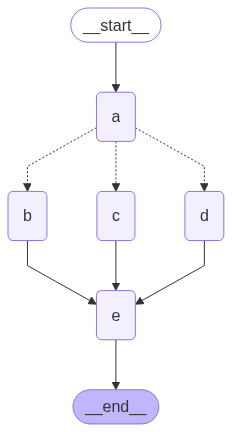

In [29]:
from langgraph.graph import StateGraph, START, END

workflow = StateGraph(State)

workflow.add_node("a", node_a)
workflow.add_node("b", node_b)
workflow.add_node("c", node_c)
workflow.add_node("d", node_d)
workflow.add_node("e", node_e)

intermidiates = ["b", "c", "d"]
workflow.add_edge(START, "a")
workflow.add_conditional_edges(
    "a",
    conditional_routing,
    intermidiates
)
for node_name in intermidiates:
    workflow.add_edge(node_name, "e")

app = workflow.compile()

app

In [35]:
app.invoke({"query" : "bd"})

{'query': 'bd',
 'messages': [HumanMessage(content='bd', additional_kwargs={}, response_metadata={}, id='d03068b0-0f23-42d4-8c1d-5209bc707fb8'),
  AIMessage(content="저는 'a'를 방문했습니다.", additional_kwargs={}, response_metadata={}, id='619c9a6a-30e5-4e18-8951-9b18e92f2f26'),
  AIMessage(content="저는 'b'를 방문했습니다.", additional_kwargs={}, response_metadata={}, id='cc9681d4-3fe2-41e4-931f-27a7e7f694cc'),
  AIMessage(content="저는 'd'를 방문했습니다.", additional_kwargs={}, response_metadata={}, id='ab621af8-6f9b-4173-978b-705f3af39f71'),
  AIMessage(content="저는 'e'를 방문했습니다.", additional_kwargs={}, response_metadata={}, id='87c16ca9-184e-419e-a236-3a4be58a074c')]}